In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import PIL, cv2, os, imghdr

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
data_dir = 'datasets/flower_photos' 

In [4]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [5]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [6]:
img_x = 160
img_y = 160

In [7]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(img_x,img_x))

Found 1687 files belonging to 3 classes.


In [8]:
data = data.map(lambda x,y: (x/255, y))

In [9]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [10]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [11]:
logdir='logs'

In [12]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [13]:
tf.keras.backend.clear_session()

In [14]:

batch_size=16
epochs=10

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",  input_shape=(img_x,  img_y, 3)),
    layers.experimental.preprocessing.RandomFlip("vertical",  input_shape=(img_x,  img_y, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
      
  ]
)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    data_augmentation,
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(6)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

hist_aug = model.fit(train, batch_size=batch_size, epochs=epochs, validation_data=val, callbacks=[tensorboard_callback, early_stopping])


Epoch 1/10
37/37 [==============================] - 129s 3s/step - loss: 1.0590 - accuracy: 0.5101 - val_loss: 0.7192 - val_accuracy: 0.7406
Epoch 2/10
37/37 [==============================] - 126s 3s/step - loss: 0.6573 - accuracy: 0.7407 - val_loss: 0.6269 - val_accuracy: 0.7344
Epoch 3/10
37/37 [==============================] - 123s 3s/step - loss: 0.6080 - accuracy: 0.7525 - val_loss: 0.4596 - val_accuracy: 0.8125
Epoch 4/10
37/37 [==============================] - 124s 3s/step - loss: 0.4940 - accuracy: 0.8100 - val_loss: 0.4640 - val_accuracy: 0.8531
Epoch 5/10
37/37 [==============================] - 122s 3s/step - loss: 0.4303 - accuracy: 0.8345 - val_loss: 0.5007 - val_accuracy: 0.8062
Epoch 6/10
37/37 [==============================] - 125s 3s/step - loss: 0.4571 - accuracy: 0.8226 - val_loss: 0.4369 - val_accuracy: 0.7969
Epoch 7/10
37/37 [==============================] - 123s 3s/step - loss: 0.4123 - accuracy: 0.8361 - val_loss: 0.5347 - val_accuracy: 0.7812
Epoch 8/10
37

In [17]:
model.evaluate(test)

5/5 [==============================] - 6s 777ms/step - loss: 0.3447 - accuracy: 0.8687


[0.344730406999588, 0.8687499761581421]

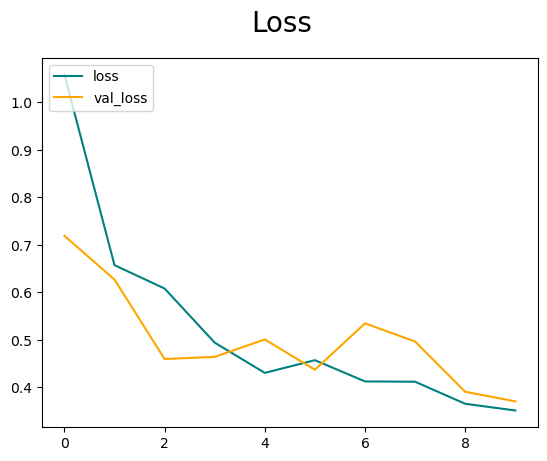

In [20]:
fig = plt.figure()
plt.plot(hist_aug.history['loss'], color='teal', label='loss')
plt.plot(hist_aug.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

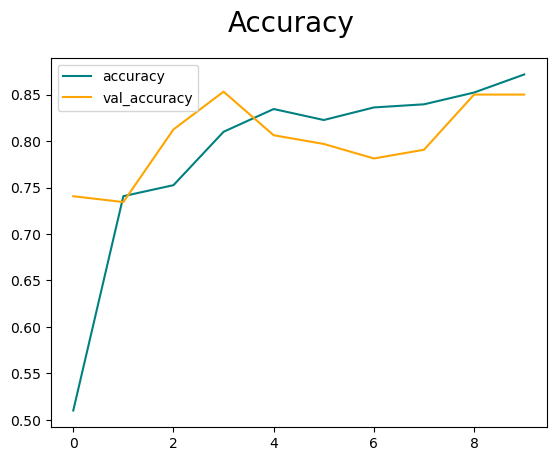

In [21]:
fig = plt.figure()
plt.plot(hist_aug.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_aug.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()